# Import Library

In [701]:
import mnist

In [702]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [703]:
# mx.set_default_device(mx.gpu)

# GAN Architecture

## Generator 👨🏻‍🎨

In [704]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim, 0.8),
        nn.LeakyReLU(0.2)
    )

In [705]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int = 256):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),

            nn.Linear(hidden_dim * 4,im_dim),
        )
        
    def __call__(self, noise):
        x = self.gen(noise)
        return mx.tanh(x)

In [706]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=512, bias=True)
      (layers.1): BatchNorm(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=1024, bias=True)
      (layers.1): BatchNorm(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): LeakyReLU()
    )
    (layers.3): Linear(input_dims=1024, output_dims=784, bias=True)
  )
)

In [707]:
# make 2D noise with shape n_samples x z_dim
def get_noise(n_samples:list[int], z_dim:int)->list[int]:
    return mx.random.normal(shape=(n_samples, z_dim))

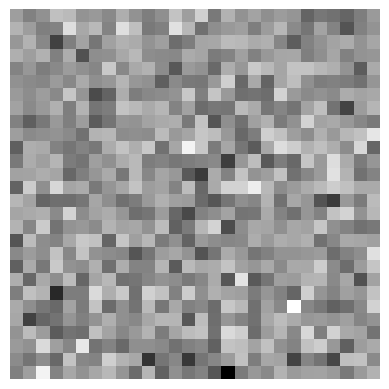

In [708]:
img = get_noise(28,28)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Discriminator 🕵🏻‍♂️

In [709]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2),
    )

In [710]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 256):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),
            
            nn.Dropout(0.3),
            nn.Linear(hidden_dim,1),
            # nn.Sigmoid()
        )
        
    def __call__(self, noise):
        x = noise + 1.0
        x = self.disc(noise)
        out = mx.log(mx.softmax(x)) 
        return out

In [711]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=1024, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=1024, output_dims=512, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.3): Dropout(p=0.30000000000000004)
    (layers.4): Linear(input_dims=256, output_dims=1, bias=True)
  )
)

# Model Training 🏋🏻‍♂️

### Losses

#### Discriminator Loss

In [712]:
def disc_loss(gen, disc, real, num_images, z_dim):
    
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
        
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
        
    fake_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels)
    
    real_disc = disc(real)
    real_labels = mx.ones((real.shape[0],1))

    real_loss = nn.losses.binary_cross_entropy(real_disc,real_labels)

    disc_loss = (fake_loss + real_loss) / 2

    return disc_loss

#### Generator Loss

In [713]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    
    fake_images = gen(noise)
    fake_disc = disc(fake_images)

    fake_labels = mx.ones((fake_images.shape[0],1))
            
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels)

    return gen_loss

In [714]:
# Get only the training images
train_images,*_ = map(np.array, mnist.mnist())

In [715]:
# Normalize the images to fall between -1,1
train_images = train_images * 2.0 - 1.0

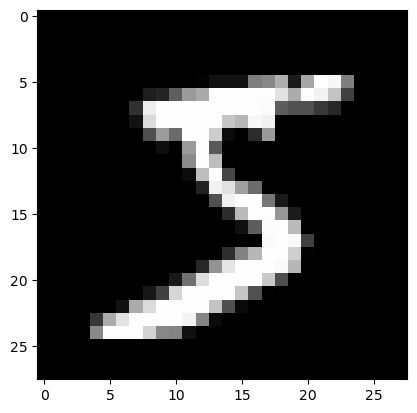

In [716]:
plt.imshow(train_images[0].reshape(28,28),cmap='gray')

In [717]:
def batch_iterate(batch_size: int, ipt: list[int])-> list[int]:
    perm = np.random.permutation(len(ipt))
    for s in range(0, len(ipt), batch_size):
        ids = perm[s : s + batch_size]
        yield ipt[ids]

In [718]:
def show_images(imgs:list[int],num_imgs:int = 25):
    if (imgs.shape[0] > 0): 
        fig,axes = plt.subplots(5, 5, figsize=(5, 5))
        
        for i, ax in enumerate(axes.flat):
            img = mx.array(imgs[i]).reshape(28,28)
            ax.imshow(img,cmap='gray')
            ax.axis('off')
        plt.show()

### show first batch of images

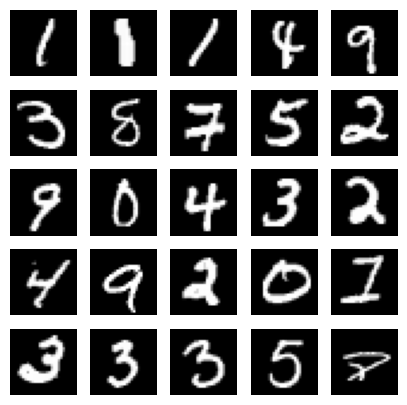

In [719]:
X = batch_iterate(25, train_images)
for x in X:  
    show_images(x)
    break

### Training Cycle

In [720]:
lr = 1e-6
z_dim = 8

gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999]) #,betas=[0.5, 0.9]

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr, betas=[0.5, 0.999])

  0%|          | 1/200 [00:05<18:14,  5.50s/it]

Losses D=array(2.29126, dtype=float32) G=array(4.85983, dtype=float32)


  1%|          | 2/200 [00:10<17:36,  5.33s/it]

Losses D=array(2.29126, dtype=float32) G=array(4.85983, dtype=float32)


  2%|▏         | 3/200 [00:15<17:25,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)


  2%|▏         | 4/200 [00:21<17:13,  5.27s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)


  2%|▎         | 5/200 [00:26<17:06,  5.26s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)


  3%|▎         | 6/200 [00:31<17:02,  5.27s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)


  4%|▎         | 7/200 [00:36<16:53,  5.25s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)


  4%|▍         | 8/200 [00:42<16:45,  5.23s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  4%|▍         | 9/200 [00:47<16:37,  5.22s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  5%|▌         | 10/200 [00:52<16:32,  5.22s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85983, dtype=float32)
Step 10: Generator loss: array(4.85982, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


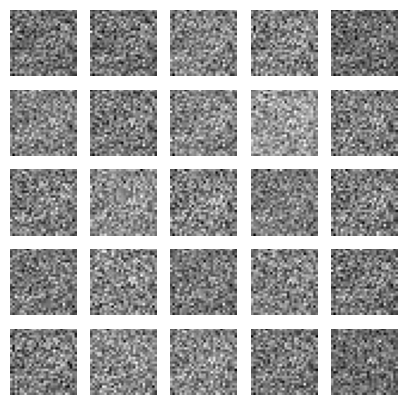

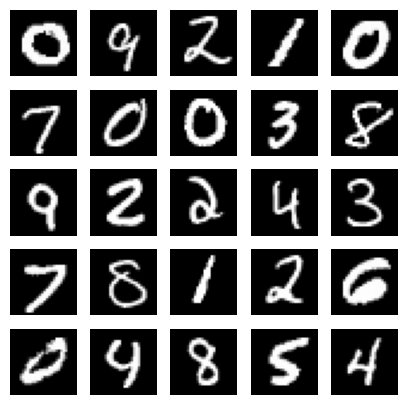

  6%|▌         | 11/200 [00:58<17:02,  5.41s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  6%|▌         | 12/200 [01:03<16:49,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  6%|▋         | 13/200 [01:08<16:36,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  7%|▋         | 14/200 [01:14<16:27,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  8%|▊         | 15/200 [01:20<17:14,  5.59s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  8%|▊         | 16/200 [01:25<17:00,  5.55s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  8%|▊         | 17/200 [01:31<16:39,  5.46s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


  9%|▉         | 18/200 [01:36<16:20,  5.39s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 10%|▉         | 19/200 [01:41<16:08,  5.35s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 10%|█         | 20/200 [01:46<15:56,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 10%|█         | 21/200 [01:52<15:48,  5.30s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)
Step 21: Generator loss: array(4.85982, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


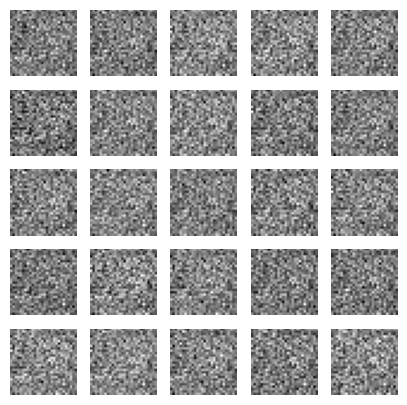

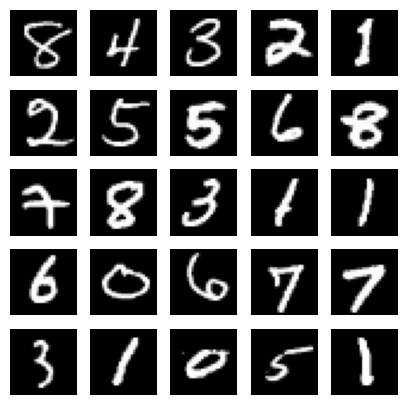

 11%|█         | 22/200 [01:58<16:17,  5.49s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 12%|█▏        | 23/200 [02:03<15:57,  5.41s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 12%|█▏        | 24/200 [02:08<15:44,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 12%|█▎        | 25/200 [02:13<15:31,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 13%|█▎        | 26/200 [02:19<15:24,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 14%|█▎        | 27/200 [02:24<15:17,  5.30s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 14%|█▍        | 28/200 [02:29<15:13,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 14%|█▍        | 29/200 [02:34<15:03,  5.28s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85982, dtype=float32)


 15%|█▌        | 30/200 [02:40<14:57,  5.28s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 16%|█▌        | 31/200 [02:45<14:50,  5.27s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 31: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


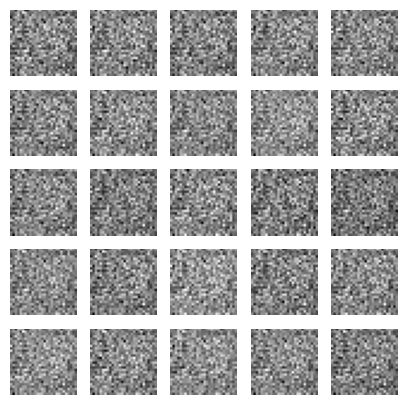

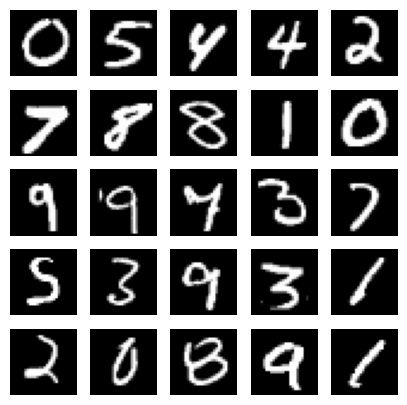

 16%|█▌        | 32/200 [02:51<15:13,  5.43s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 16%|█▋        | 33/200 [02:56<15:01,  5.40s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 17%|█▋        | 34/200 [03:01<14:50,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 18%|█▊        | 35/200 [03:07<14:40,  5.34s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 18%|█▊        | 36/200 [03:12<14:35,  5.34s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 18%|█▊        | 37/200 [03:17<14:27,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 19%|█▉        | 38/200 [03:23<14:23,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 20%|█▉        | 39/200 [03:28<14:16,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 20%|██        | 40/200 [03:33<14:09,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 20%|██        | 41/200 [03:38<14:00,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 21%|██        | 42/200 [03:44<13:57,  5.30s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 42: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


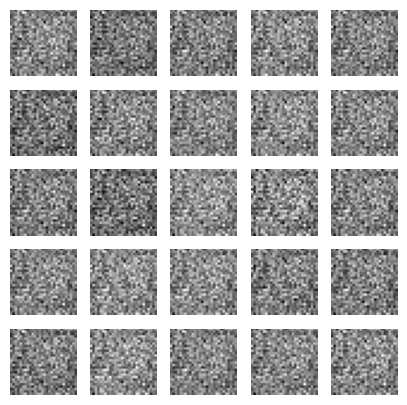

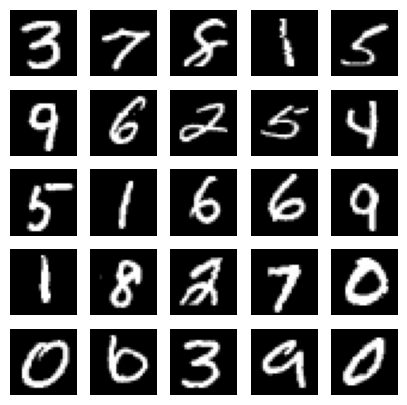

 22%|██▏       | 43/200 [03:50<14:19,  5.47s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 22%|██▏       | 44/200 [03:55<14:07,  5.43s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 22%|██▎       | 45/200 [04:00<13:56,  5.40s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 23%|██▎       | 46/200 [04:06<13:45,  5.36s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 24%|██▎       | 47/200 [04:11<13:36,  5.34s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 24%|██▍       | 48/200 [04:16<13:30,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 24%|██▍       | 49/200 [04:21<13:23,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 25%|██▌       | 50/200 [04:27<13:17,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 26%|██▌       | 51/200 [04:32<13:10,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 26%|██▌       | 52/200 [04:37<13:03,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 26%|██▋       | 53/200 [04:43<12:57,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 53: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


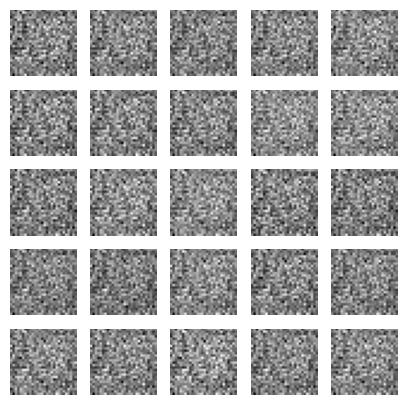

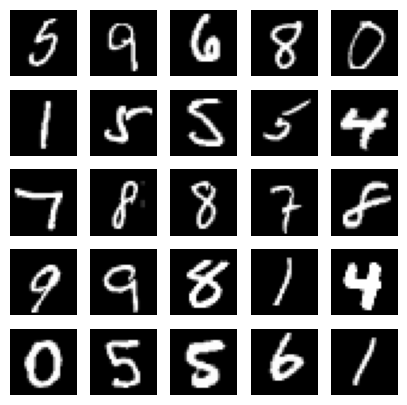

 27%|██▋       | 54/200 [04:48<13:18,  5.47s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 28%|██▊       | 55/200 [04:54<13:04,  5.41s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 28%|██▊       | 56/200 [04:59<12:53,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 28%|██▊       | 57/200 [05:05<13:03,  5.48s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 29%|██▉       | 58/200 [05:10<12:50,  5.43s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 30%|██▉       | 59/200 [05:15<12:36,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 30%|███       | 60/200 [05:20<12:23,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 30%|███       | 61/200 [05:26<12:20,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 31%|███       | 62/200 [05:31<12:12,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 32%|███▏      | 63/200 [05:36<12:04,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 63: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


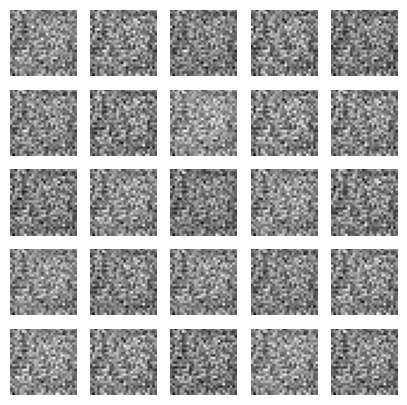

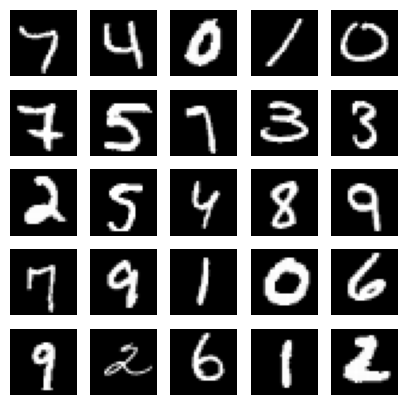

 32%|███▏      | 64/200 [05:42<12:21,  5.45s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 32%|███▎      | 65/200 [05:47<12:08,  5.40s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 33%|███▎      | 66/200 [05:53<11:57,  5.36s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 34%|███▎      | 67/200 [05:58<11:49,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 34%|███▍      | 68/200 [06:03<11:42,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 34%|███▍      | 69/200 [06:08<11:34,  5.30s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 35%|███▌      | 70/200 [06:14<11:27,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 36%|███▌      | 71/200 [06:19<11:21,  5.28s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 36%|███▌      | 72/200 [06:24<11:16,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 36%|███▋      | 73/200 [06:30<11:15,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 37%|███▋      | 74/200 [06:35<11:08,  5.30s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 74: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


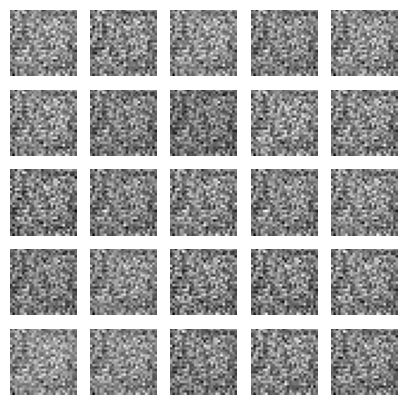

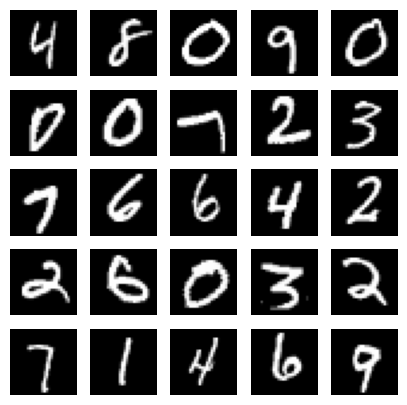

 38%|███▊      | 75/200 [06:41<11:24,  5.48s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 38%|███▊      | 76/200 [06:46<11:10,  5.40s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 38%|███▊      | 77/200 [06:51<10:58,  5.36s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 39%|███▉      | 78/200 [06:57<10:50,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 40%|███▉      | 79/200 [07:02<10:44,  5.32s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 40%|████      | 80/200 [07:07<10:36,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 40%|████      | 81/200 [07:12<10:29,  5.29s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 41%|████      | 82/200 [07:18<10:22,  5.28s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 42%|████▏     | 83/200 [07:23<10:18,  5.28s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 42%|████▏     | 84/200 [07:28<10:16,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 42%|████▎     | 85/200 [07:34<10:11,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 85: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


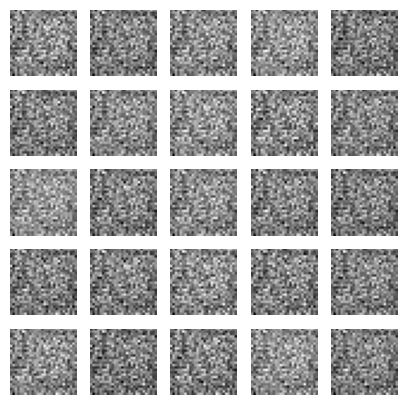

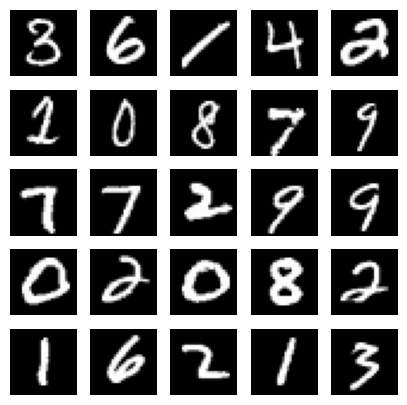

 43%|████▎     | 86/200 [07:40<10:24,  5.48s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 44%|████▎     | 87/200 [07:45<10:13,  5.43s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 44%|████▍     | 88/200 [07:50<10:01,  5.37s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 44%|████▍     | 89/200 [07:55<09:51,  5.33s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 45%|████▌     | 90/200 [08:01<09:43,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 46%|████▌     | 91/200 [08:06<09:38,  5.31s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 46%|████▌     | 92/200 [08:12<09:55,  5.51s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 46%|████▋     | 93/200 [08:17<09:48,  5.50s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 47%|████▋     | 94/200 [08:23<09:42,  5.50s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 48%|████▊     | 95/200 [08:28<09:36,  5.49s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)
Step 95: Generator loss: array(4.85981, dtype=float32), discriminator loss: array(2.4338, dtype=float32)


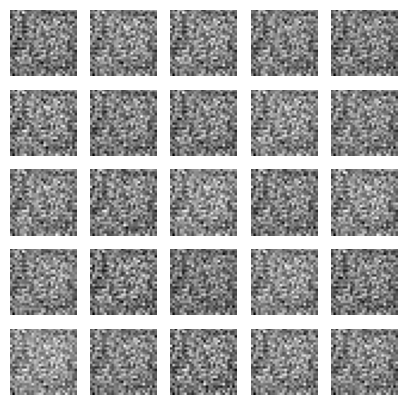

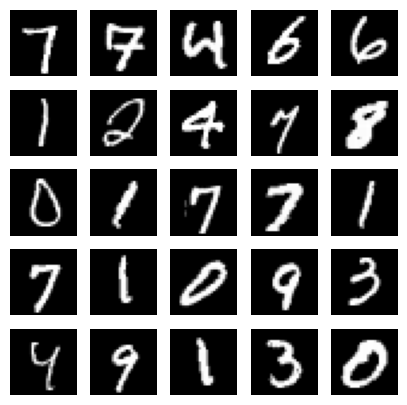

 48%|████▊     | 96/200 [08:35<10:05,  5.82s/it]

Losses D=array(2.29125, dtype=float32) G=array(4.85981, dtype=float32)


 48%|████▊     | 96/200 [08:39<09:22,  5.41s/it]


KeyboardInterrupt: 

In [721]:
# Set your parameters
n_epochs = 200
display_step = 5000
cur_step = 0

batch_size = 128

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in tqdm(range(n_epochs)):

    for real in batch_iterate(batch_size, train_images):
                
        # TODO Train Discriminator
        D_loss,D_grads = D_loss_grad(gen, disc,mx.array(real), batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        mx.eval(disc.parameters(), disc_opt.state)

        # TODO Train Generator
        G_loss,G_grads = G_loss_grad(gen, disc, batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients
        mx.eval(gen.parameters(), gen_opt.state)        
        
        if (cur_step + 1) % display_step == 0:
            print(f"Step {epoch}: Generator loss: {G_loss}, discriminator loss: {D_loss}")
            fake_noise = mx.array(get_noise(batch_size, z_dim))
            fake = gen(fake_noise)
            show_images(fake)
            show_images(real)
        cur_step += 1

    print('Losses D={0} G={1}'.format(D_loss,G_loss))